In [21]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from protein_dataset import ProteinDataset
import constants as CONSTANTS
from models.basic_vae_1 import BasicVAE1
from models.vae_loss import VAELoss


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BasicVAE1()
model.to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
batch_size = 20
n_epochs = 5
print_every = 2
test_every = 2
plot_every = 2

In [23]:
train_dataset = ProteinDataset(CONSTANTS.TRAIN_FILE)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(train_dataset.__len__())
x, y = train_dataset.__getitem__(0)
print(x.shape, y.shape)
len(train_loader)

3ndo: 1-hot size: torch.Size([450, 20]) contact-map size: torch.Size([450, 450])
1a1g: 1-hot size: torch.Size([84, 20]) contact-map size: torch.Size([84, 84])
200
torch.Size([1, 20, 64]) torch.Size([32, 32])


10

In [24]:
val_dataset = ProteinDataset(CONSTANTS.VAL_FILE)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(val_loader))

test_dataset = ProteinDataset(CONSTANTS.TEST_FILE)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(test_loader))

3ne0: 1-hot size: torch.Size([208, 20]) contact-map size: torch.Size([208, 208])
2
3ndq: 1-hot size: torch.Size([97, 20]) contact-map size: torch.Size([97, 97])
1


In [28]:
def train():
    model.train()
    loss = 0.0
    losses = []
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        #         print(x.shape, y.shape)
        optimizer.zero_grad()
        y_prime, mu, logvar = model(x)
        # print(y_prime.shape)
        # y_prime.squeeze_(0)
        loss = criterion(y, y_prime, mu, logvar)
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()
        

In [19]:
train()

torch.Size([20, 1, 32, 32]) torch.Size([20, 32, 32])


8054.13037109375

In [ ]:
def test(data_loader):
    model.eval()
    loss = 0.0
    losses = []
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        y_prime, mu, logvar = model(x)
        loss = criterion(y, y_prime, mu, logvar)
        losses.append(loss)
    return torch.stack(losses).mean().item()

torch.Size([20, 1, 32, 32]) torch.Size([20, 32, 32])


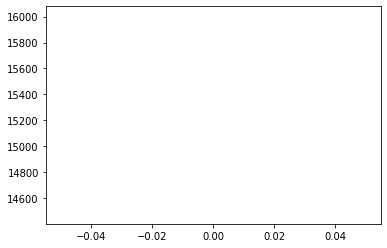

torch.Size([20, 1, 32, 32]) torch.Size([20, 32, 32])
torch.Size([20, 1, 32, 32]) torch.Size([20, 32, 32])


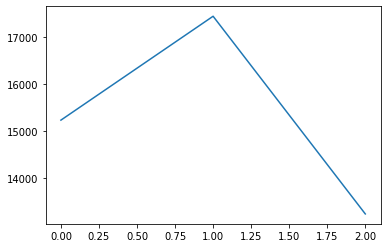

torch.Size([20, 1, 32, 32]) torch.Size([20, 32, 32])
torch.Size([20, 1, 32, 32]) torch.Size([20, 32, 32])


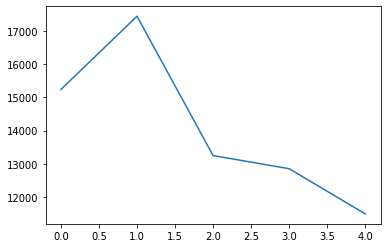

In [29]:
train_losses = []
val_losses = []
best_test_loss = np.inf
for epoch in range(1, n_epochs+1):
    train_loss = train()
    train_losses.append(train_loss)
    
    if epoch % print_every == 0:
        print("epoch:{}/{}, train_loss: {:.5f}".format(epoch, n_epochs+1, train_loss))
    
    if epoch % test_every == 0:
        val_loss = test(val_loader)
        print("epoch:{}/{}, val_loss: {:.5f}".format(epoch, n_epochs+1, val_loss))
        val_losses.append(val_loss)
        if val_loss < best_test_loss:
            print('Updating best test loss: {:.5f}'.format(best_test_loss))
            torch.save(model.state_dict(),'outputs/best_model.pth')
    
    if epoch % plot_every == 0:
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()

In [ ]:
test_loss = test(test_loader)
test_loss